# Patch Foraging Simulation
To-Do List:
- Lower false alarm bin size by dividing rate by decrement factor (e.g. if decrease bin size by n, then divide fa rate by n)
- Plot comparison of behavioral data with simulation data
- Make RL agent for task


## Initial setup

In [1]:
import numpy as np
import math
from random import random, randint
import matplotlib.pyplot as plt
% matplotlib inline

## Fixed Model

### Create environment

In [2]:
class PatchEnvironment:
    
    def __init__(self,
                 d_interpatch, 
                 r_init, 
                 decay=0.1,
                 nc_avg=1.0,
                 target_duration=1.0,
                 max_trial_duration=4.0,
                 iti=1.5,
                 fa_timeout=4.0,
                 end_patch_type=None,
                 end_patch_val=None):
        
        # Patch settings
        self.d_interpatch = d_interpatch
        self.r_init = r_init
        self.decay = decay
        self.nc_avg = nc_avg
        self.target_duration = target_duration
        self.max_trial_duration = max_trial_duration
        self.iti = iti
        self.fa_timeout = fa_timeout
        self.end_patch_type = end_patch_type
        if isinstance(end_patch_val, list):
            self.end_patch_params = end_patch_val
            self.end_patch_val = randint(end_patch_val[0], end_patch_val[1])
        else:
            self.end_patch_params = None
            self.end_patch_val = end_patch_val
        
        # Tracking indices
        self.trial = 0
         
    def reset_patch(self):
        self.trial = 0
        if self.end_patch_params is not None:
            self.end_patch_val = randint(self.end_patch_params[0], self.end_patch_params[1])
    
    def create_trial(self):
        """
        Creates trial based on patch settings. If patch is depleted, then return no targets.
        Otherwise, return delay to target sampled from exponential distribution (flat hazard rate).
        
        Returns:
        - nc_time: duration of delay to target
        - catch_trial: True if catch trial
        """
        if self.is_patch_depleted():
            return self.max_trial_duration, False
        else:
            lambda_ = 1.0 / self.nc_avg
            nc_time = -(1.0/lambda_) * math.log(1.0 - random()) # inverse transform sampling of exponential distribution
            
            if nc_time > self.max_trial_duration:
                nc_time = self.max_trial_duration
                catch_trial = True
            else:
                catch_trial = False
            
            return nc_time, catch_trial
    
    def give_reward(self):
        # Give current reward volume based on reward function and patch end function
        if self.is_patch_depleted():
            return 0.0
        else:
            return self._get_reward_volume()
    
    def increment_counter(self, n=1):
        self.trial += n
    
    def _get_reward_volume(self):
        return self.r_init * (1 - self.decay)**self.trial
    
    def is_patch_depleted(self):
        if self.end_patch_type == None:
            return False
        elif self.end_patch_type == 'reward':
            return self._get_reward_volume() < self.end_patch_val
        elif self.end_patch_type == 'trial':
            return self.trial >= self.end_patch_val
        else:
            raise ValueError('Unknown end patch type %s' % self.end_patch_type)

In [412]:
class Rodent:
    
    def __init__(self, 
                 hit_rate, 
                 fa_rate, 
                 velocity, 
                 decision_type='reward', 
                 decision_val=2.0):
        
        self.hit_rate = hit_rate
        self.fa_rate = fa_rate
        self.velocity = velocity
        self.decision_type = decision_type
        self.decision_val = decision_val
        
        self.result_idx = {'hit': 0,
                           'miss': 1,
                           'false_alarm': 2,
                           'catch': 3}
        
    def leave_patch(self, last_reward, t_patch, n_patch):
        """
        Either choose to stay in patch (and harvest reward) or leave patch (and incur travel time delay).
        Args:
        - last_reward: last reward harvested in patch (or 0 if none harvested)
        - t_patch: time spent in current patch
        - n_patch: number of trials in current patch
        
        Returns:
        - boolean that is True if animal decides to leave patch
        """
        
        if self.decision_type == 'reward':
            if n_patch == 0:
                return False
            else:
                return last_reward <= self.decision_val
        elif self.decision_type == 'time':
            return t_patch >= self.decision_val
        elif self.decision_type == 'trial':
            return n_patch >= self.decision_val
        else:
            raise ValueError('Decision type %s not recognized.' % self.decision_type)
    
    def harvest_reward(self, nc_duration, target_duration, catch_trial=False):
        """
        Attempt to collect reward given limitations of parameters.
        Args:
        - nc_duration: delay to target start
        - target_duration: length of target tone
        - catch_trial: True if catch trial
        
        Returns:
        - result: indexed result based on dictionary above
        - t_result: time from trial start to when result occurred
        """
        # Model false alarm as n Bernoulli trials
        num_blocks = nc_duration / target_duration
        n = 5 # scaling factor for precision
        fa_in_block = (self.fa_rate/n) > np.random.rand(int(num_blocks*n)) # true if FA in time block
        false_alarm = np.sum(fa_in_block) > 0 # FA occurred in any time block
        
        # (cannot use binomial distribution since lose time information)
        #num_blocks = nc_duration / target_duration # standard bin size
        #p_no_fa = (1.0 - self.fa_rate)**(num_blocks) # p(~fa)^n
        #false_alarm = random() > p_no_fa # or random() < (1-p_no_fa)
        
        # False alarm
        if false_alarm:
            # Time to false alarm = bin_idx * t_bin
            t_fa = (np.nonzero(fa_in_block)[0][0] + 0.5) * (target_duration/n)
            return self.result_idx['false_alarm'], t_fa
        
        # Get reward if no false alarm during catch trial
        elif catch_trial:
            return self.result_idx['catch'], nc_duration

        # Otherwise, get reward based on hit rate
        elif self.hit_rate > random():
            return self.result_idx['hit'], nc_duration + target_duration / 2
        else:
            return self.result_idx['miss'], nc_duration + target_duration
    
    def get_travel_time(self, distance):
        return distance / self.velocity

In [4]:
def run_simulation(num_steps, mouse, patch, verbose=False):

    n_patch = 0 # trial number
    t_patch = 0.0 # time in patch
    t_total = 0.0 # total time
    r_total = 0.0 # total reward harvested
    num_patches = 1 # number of patches explored
    r_last = math.inf # last reward in patch

    for i in range(num_steps):

        # Make stay or go decision
        leave = mouse.leave_patch(r_last, t_patch, n_patch)

        # If leave, incur travel cost and reset patch
        if leave:
            r_step = 0.0
            t_step = mouse.get_travel_time(patch.d_interpatch)
            n_patch = 0
            t_patch = 0.0
            r_last = math.inf
            num_patches += 1
            patch.reset_patch()

        # Otherwise, attempt signal detection task to harvest reward
        else:
            # Get trial from patch
            nc_time, catch_trial = patch.create_trial()
            result, t_result = mouse.harvest_reward(nc_time, patch.target_duration, catch_trial)

            # Penalize with timeout if false alarm
            if (result == 2):
                r_step = 0.0
                t_step = t_result + patch.fa_timeout + patch.iti

            # Get reward if hit or successful catch trial
            elif (result == 0) or (result == 3): 
                r_step = patch.give_reward()
                r_last = r_step
                t_step = nc_time + patch.target_duration * (1 - catch_trial) + patch.iti

            # Do not reward but do not penalize if miss
            elif (result == 1):
                r_step = 0.0
                t_step = nc_time + patch.target_duration + patch.iti

            else:
                raise ValueError('Unknown result index: %d' % result)

            # Increment patch counters
            patch.increment_counter()
            n_patch += 1
            t_patch += t_step

        # Increment global counters
        t_total += t_step
        r_total += r_step

        # Print progress
        if verbose and (i % 100 == 0):
            print("Step %d" % i)
    
    if verbose:
        harvest_rate = r_total / t_total
        print("Total reward: %.2f uL" % r_total)
        print("Total time: %.2f s" % t_total)
        print("Harvest rate: %.3f uL/s" % harvest_rate)
    
    return r_total, t_total, num_patches

### Sanity check
Step-by-step walkthrough to check for blatant errors.

In [ ]:
n_patch = 0 # trial number
t_patch = 0.0 # time in patch
t_total = 0.0 # total time
r_total = 0.0 # total reward harvested
num_patches = 1 # number of patches explored
r_last = math.inf # last reward in patch
verbose = True
num_steps = 10

for i in range(num_steps):

    # Make stay or go decision
    leave = mouse.leave_patch(r_last, t_patch, n_patch)

    # If leave, incur travel cost and reset patch
    if leave:
        r_step = 0.0
        t_step = mouse.get_travel_time(patch.d_interpatch)
        n_patch = 0
        t_patch = 0.0
        r_last = math.inf
        num_patches += 1
        patch.reset_patch()

    # Otherwise, attempt signal detection task to harvest reward
    else:
        # Get trial from patch
        nc_time, catch_trial = patch.create_trial()
        result, t_result = mouse.harvest_reward(nc_time, patch.target_duration, catch_trial)

        # Penalize with timeout if false alarm
        if (result == 2):
            r_step = 0.0
            t_step = t_result + patch.fa_timeout + patch.iti

        # Get reward if hit or successful catch trial
        elif (result == 0) or (result == 3): 
            r_step = patch.give_reward()
            r_last = r_step
            t_step = nc_time + patch.target_duration * (1 - catch_trial) + patch.iti

        # Do not reward but do not penalize if miss
        elif (result == 1):
            r_step = 0.0
            t_step = nc_time + patch.target_duration + patch.iti

        else:
            raise ValueError('Unknown result index: %d' % result)

        # Increment patch counters
        patch.increment_counter()
        n_patch += 1
        t_patch += t_step

    # Increment global counters
    t_total += t_step
    r_total += r_step

    # Print progress
    if verbose and (i % 100 == 0):
        print("Step %d" % i)

if verbose:
    harvest_rate = r_total / t_total
    print("Total reward: %.2f uL" % r_total)
    print("Total time: %.2f s" % t_total)
    print("Harvest rate: %.3f uL/s" % harvest_rate)

### Hit rate = 1.0, FA rate = 0.0 (control)

#### Run simulation

In [30]:
# Environment parameters
d_interpatch = 25.0
r_init = 12.0
decay = 0.1
nc_avg = 1.0
target_duration = 1.0
max_trial_duration = 4.0
iti = 1.5
fa_timeout = 4.0
end_patch_type = None
end_patch_val = None

# Animal parameters
hit_rate = 1.0
fa_rate = 0.0
velocity = 5.0
decision_type = 'reward'
decision_val = np.linspace(2.0, 12.0, num=int((12.0-2.0)/0.1)+1)

# Experiment parameters
exp_name = 'trial_1'
num_steps_per_sim= 1000
num_sims_per_value = 5

# Create environment
patch = PatchEnvironment(d_interpatch,
                         r_init, 
                         decay,
                         nc_avg=nc_avg,
                         target_duration=target_duration,
                         max_trial_duration=max_trial_duration,
                         iti=iti,
                         fa_timeout=fa_timeout,
                         end_patch_type=end_patch_type,
                         end_patch_val=end_patch_val)

# Run simulations
r_total = np.zeros([decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([decision_val.shape[0], num_sims_per_value])
for i, dv in enumerate(decision_val):
    # Create animal object
    mouse = Rodent(hit_rate,
                   fa_rate,
                   velocity,
                   decision_type,
                   dv)

    for j in range(num_sims_per_value):
        r_total[i, j], t_total[i, j], num_patches[i, j] = run_simulation(num_steps_per_sim, mouse, patch)

#### Plot performance curve

Max harvest rate: 2.20 uL/s
Reward threshold at max: 8.10 uL


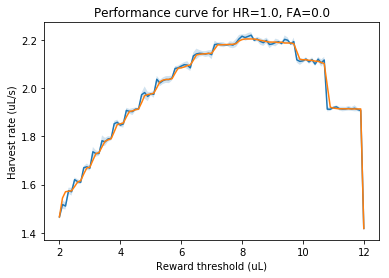

In [37]:
# Calculate harvest rate mean and std
mean = np.mean(r_total/t_total, axis=1)
std = np.std(r_total/t_total, axis=1)

# Smooth curve with 1D median filter
mean_smooth = np.zeros(mean.shape)
n = 10 # filter size
mean_smooth[0] = mean[0]
mean_smooth[-1] = mean[-1] # anchor at ends
for i in range(1, mean.shape[0]-1):
    mean_smooth[i] = np.median(mean[max(i-n//2, 0):min(i+n//2, mean.shape[0]-1)])

# Plot results
fig, ax = plt.subplots()
p_mean = ax.plot(decision_val, mean)
p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
p_mean_smooth = ax.plot(decision_val, mean_smooth)
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for HR=1.0, FA=0.0')

print("Max harvest rate: %.2f uL/s" % np.max(mean_smooth))
print("Reward threshold at max: %.2f uL" % decision_val[np.argmax(mean_smooth)])

### Multiple hit rate, fa rate combinations

#### Run simulations

In [39]:
# Experiment parameters
num_steps_per_sim= 1000
num_sims_per_value = 5
exp_name = 'trial_1'
exp_desc = 'data shape = [hit_rate, fa_rate, reward_thresh, num_sims]'

# Environment parameters
d_interpatch = 25.0
r_init = 12.0
decay = 0.1
nc_avg = 1.0
target_duration = 1.0
max_trial_duration = 4.0
iti = 1.5
fa_timeout = 4.0
end_patch_type = None
end_patch_val = None

# Animal parameters
hit_rate = np.arange(11) / 10
fa_rate = np.arange(11) / 10
velocity = 5.0
decision_type = 'reward'
decision_val = np.linspace(2.0, 12.0, num=int((12.0-2.0)/0.1)+1)

# Create environment
patch = PatchEnvironment(d_interpatch,
                         r_init, 
                         decay,
                         nc_avg=nc_avg,
                         target_duration=target_duration,
                         max_trial_duration=max_trial_duration,
                         iti=iti,
                         fa_timeout=fa_timeout,
                         end_patch_type=end_patch_type,
                         end_patch_val=end_patch_val)


# Run simulations
r_total = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
for i, hr in enumerate(hit_rate):
    for j, far in enumerate(fa_rate):
        print("Simulating hit rate %.2f, fa rate %.2f" % (hr, far))
        for k, dv in enumerate(decision_val):
            # Create animal object
            mouse = Rodent(hr,
                           far,
                           velocity,
                           decision_type,
                           dv)

            for l in range(num_sims_per_value):
                r_total[i, j, k, l], t_total[i, j, k, l], num_patches[i, j, k, l] = \
                    run_simulation(num_steps_per_sim, mouse, patch)

Simulating hit rate 0.00, fa rate 0.00
Simulating hit rate 0.00, fa rate 0.10
Simulating hit rate 0.00, fa rate 0.20
Simulating hit rate 0.00, fa rate 0.30
Simulating hit rate 0.00, fa rate 0.40
Simulating hit rate 0.00, fa rate 0.50
Simulating hit rate 0.00, fa rate 0.60
Simulating hit rate 0.00, fa rate 0.70
Simulating hit rate 0.00, fa rate 0.80
Simulating hit rate 0.00, fa rate 0.90
Simulating hit rate 0.00, fa rate 1.00
Simulating hit rate 0.10, fa rate 0.00
Simulating hit rate 0.10, fa rate 0.10
Simulating hit rate 0.10, fa rate 0.20
Simulating hit rate 0.10, fa rate 0.30
Simulating hit rate 0.10, fa rate 0.40
Simulating hit rate 0.10, fa rate 0.50
Simulating hit rate 0.10, fa rate 0.60
Simulating hit rate 0.10, fa rate 0.70
Simulating hit rate 0.10, fa rate 0.80
Simulating hit rate 0.10, fa rate 0.90
Simulating hit rate 0.10, fa rate 1.00
Simulating hit rate 0.20, fa rate 0.00
Simulating hit rate 0.20, fa rate 0.10
Simulating hit rate 0.20, fa rate 0.20
Simulating hit rate 0.20,

#### Save results

In [108]:
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name

# Save data
np.save(results_dir + 'r_total', r_total)
np.save(results_dir + 't_total', t_total)
np.save(results_dir + 'num_patches', num_patches)
np.save(results_dir + 'hit_rate', hit_rate)
np.save(results_dir + 'fa_rate', fa_rate)

# Write settings file
f = open(results_dir + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nEnvironment params:\n')
f.write('d_interpatch = %.2f\n' % d_interpatch)
f.write('r_init = %.2f\n' % r_init)
f.write('decay = %.2f\n' % decay)
f.write('nc_avg = %.2f\n' % nc_avg)
f.write('target_duration = %.2f\n' % target_duration)
f.write('max_trial_duration = %.2f\n' % max_trial_duration)
f.write('iti = %.2f\n' % iti)
f.write('fa_timeout = %.2f\n' % fa_timeout)
f.write('end_patch_type = %s\n' % end_patch_type)
f.write('end_patch_val = %s\n' % str(end_patch_val))
f.write('\nAnimal params:\n')
if isinstance(hit_rate, np.ndarray):
    f.write('hit_rate = %s\n' %
            ('[' + ', '.join([str(hr) for hr in hit_rate]) + ']'))
else:
    f.write('hit_rate = %.2f\n' % hit_rate)
if isinstance(fa_rate, np.ndarray):
    f.write('fa_rate = %s\n' %
            ('[' + ', '.join([str(far) for far in fa_rate]) + ']'))
else:
    f.write('fa_rate = %.2f\n' % fa_rate)
f.write('velocity = %.2f\n' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    f.write('decision_val = %.2f\n' % decision_val)
f.close()

#### Plot performance curves

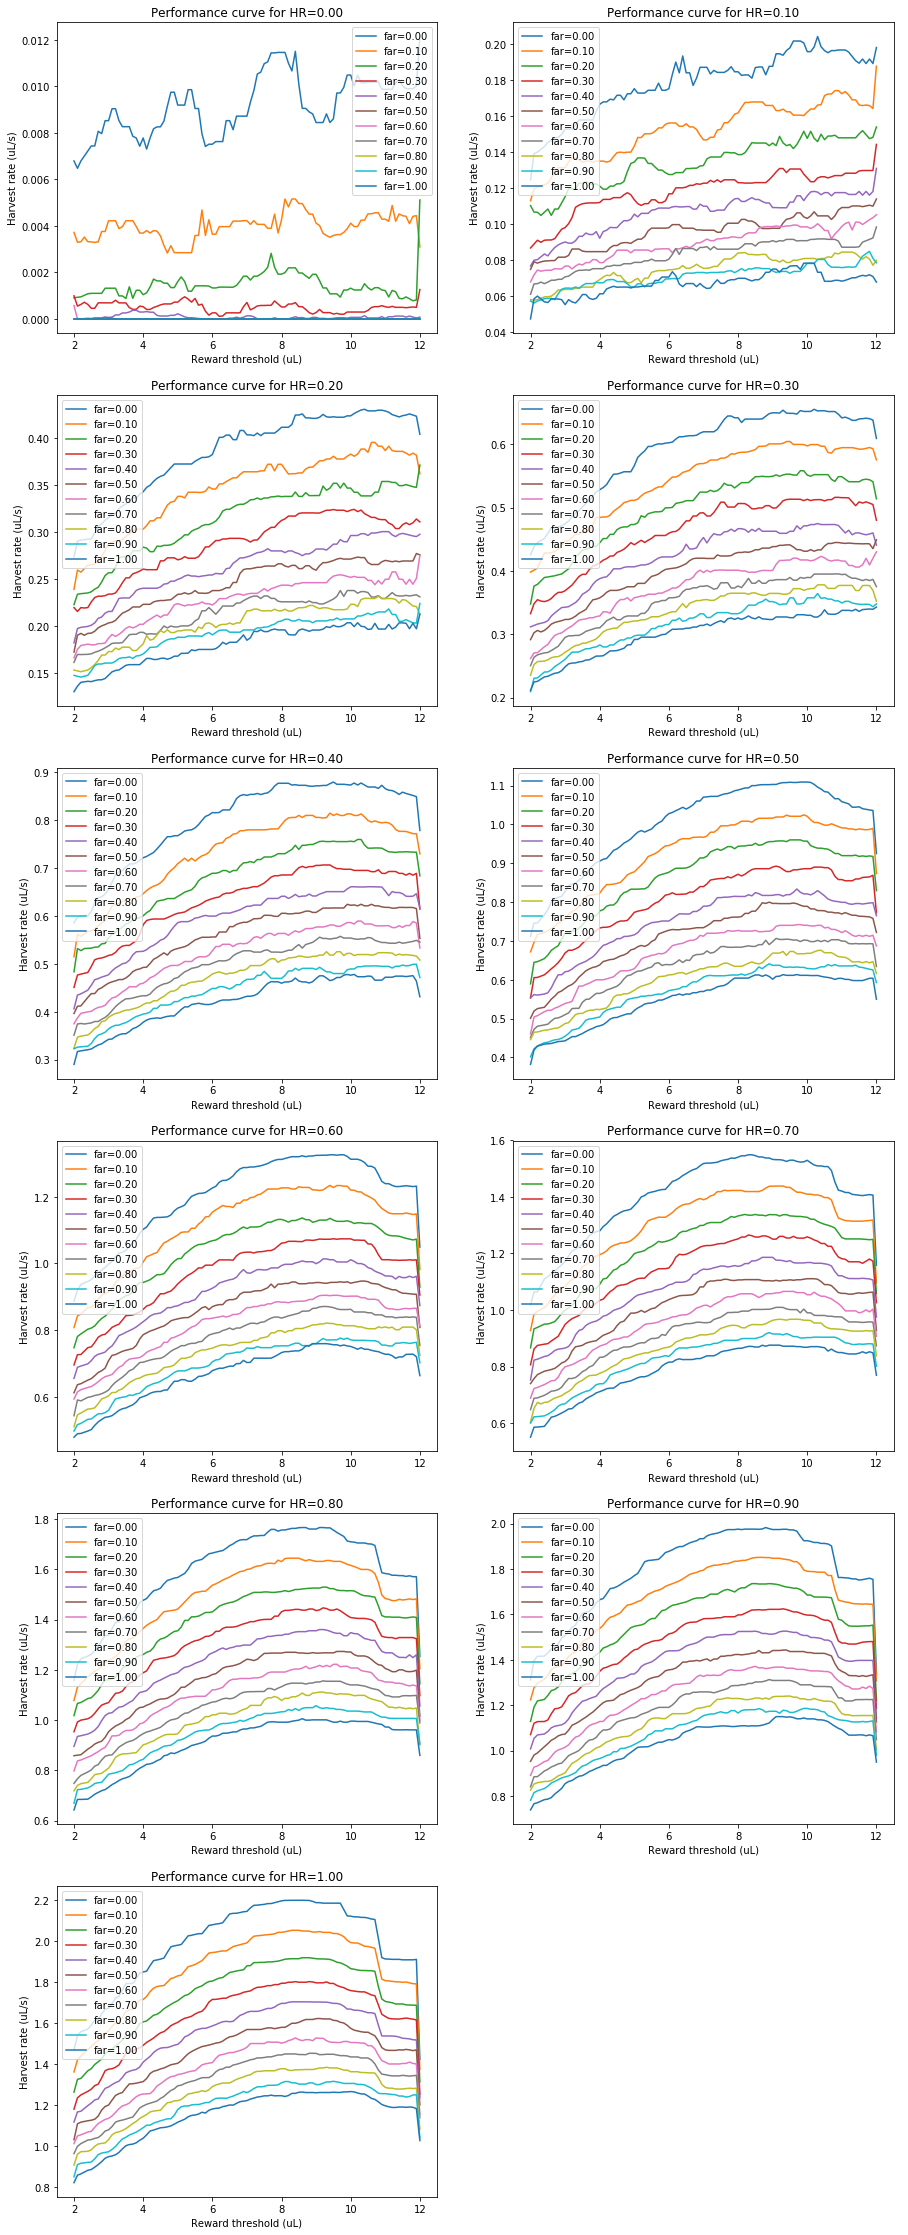

In [112]:
# Plot harvest rate vs. leaving threshold
harvest_rate = np.zeros([hit_rate.shape[0], fa_rate.shape[0]])
r_thresh = np.zeros([hit_rate.shape[0], fa_rate.shape[0]])
fig, ax = plt.subplots(fa_rate.shape[0]//2+1, 2, figsize=(15, 40))
for i, hr in enumerate(hit_rate):
    for j, far in enumerate(fa_rate):
        # Calculate harvest rate mean and std
        mean = np.mean(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)
        std = np.std(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)

        # Smooth curve with 1D median filter
        mean_smooth = np.zeros(mean.shape)
        n = 10 # filter size
        mean_smooth[0] = mean[0]
        mean_smooth[-1] = mean[-1] # anchor at ends
        for k in range(1, mean.shape[0]-1):
            mean_smooth[k] = np.median(mean[max(k-n//2, 0):min(k+n//2, mean.shape[0]-1)])
        harvest_rate[i, j] = np.max(mean_smooth)
        r_thresh[i, j] = decision_val[np.argmax(mean_smooth)]
        
        # Plot results
        #p_mean = ax.plot(decision_val, mean)
        #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
        p_mean_smooth = ax[i//2, i%2].plot(decision_val, mean_smooth, label='far=%.2f' % (far))
        
    p_xlabel = ax[i//2, i%2].set_xlabel('Reward threshold (uL)')
    p_ylabel = ax[i//2, i%2].set_ylabel('Harvest rate (uL/s)')
    p_title = ax[i//2, i%2].set_title('Performance curve for HR=%.2f' % hr)
    l = ax[i//2, i%2].legend()

_ = ax[-1, -1].axis('off')

# Save plot
plt.savefig(results_dir + 'performance_curves.png')

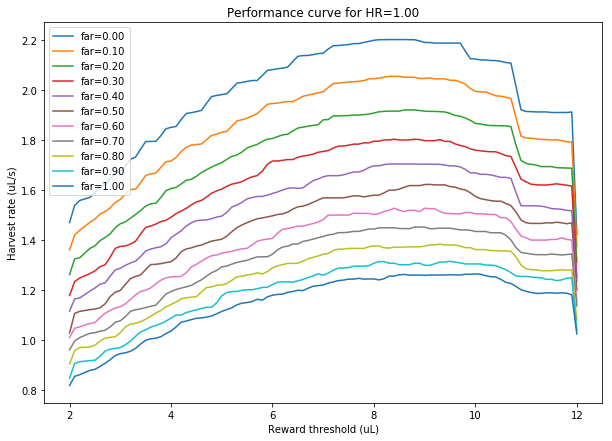

In [117]:
i = hit_rate.shape[0]-1
hr = hit_rate[i]
fig, ax = plt.subplots(figsize=(10, 7))
for j, far in enumerate(fa_rate):
    # Calculate harvest rate mean and std
    mean = np.mean(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)
    std = np.std(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)

    # Smooth curve with 1D median filter
    mean_smooth = np.zeros(mean.shape)
    n = 10 # filter size
    mean_smooth[0] = mean[0]
    mean_smooth[-1] = mean[-1] # anchor at ends
    for k in range(1, mean.shape[0]-1):
        mean_smooth[k] = np.median(mean[max(k-n//2, 0):min(k+n//2, mean.shape[0]-1)])
    harvest_rate[i, j] = np.max(mean_smooth)
    r_thresh[i, j] = decision_val[np.argmax(mean_smooth)]

    # Plot results
    #p_mean = ax.plot(decision_val, mean)
    #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
    p_mean_smooth = ax.plot(decision_val, mean_smooth, label='far=%.2f' % (far))
        
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for HR=%.2f' % hr)
l = ax.legend()

#### Plot heatmaps

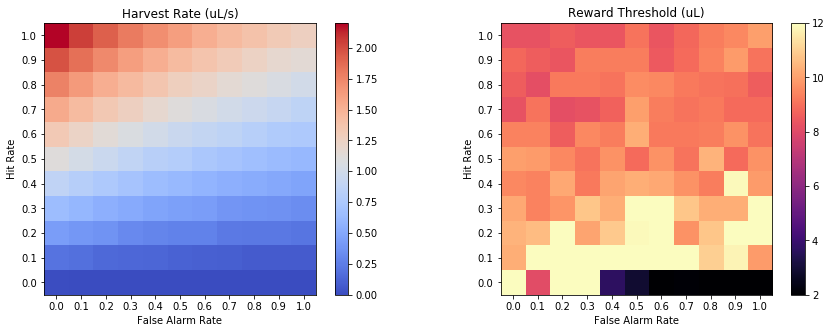

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap of harvest rate
heatmap = ax[0].imshow(harvest_rate[::-1, :], cmap='coolwarm')
cbar = fig.colorbar(heatmap, ax=ax[0])
xticks = ax[0].set_xticks(np.arange(11))
xtick_labels = ax[0].set_xticklabels(fa_rate)
yticks = ax[0].set_yticks(np.arange(11))
ytick_labels = ax[0].set_yticklabels(hit_rate[::-1])
xlabel = ax[0].set_xlabel('False Alarm Rate')
ylabel = ax[0].set_ylabel('Hit Rate')
title = ax[0].set_title('Harvest Rate (uL/s)')

# Plot heatmap of reward threshold
heatmap = ax[1].imshow(r_thresh[::-1, :], cmap='magma')
cbar = fig.colorbar(heatmap, ax=ax[1])
xticks = ax[1].set_xticks(np.arange(11))
xtick_labels = ax[1].set_xticklabels(fa_rate)
yticks = ax[1].set_yticks(np.arange(11))
ytick_labels = ax[1].set_yticklabels(hit_rate[::-1])
xlabel = ax[1].set_xlabel('False Alarm Rate')
ylabel = ax[1].set_ylabel('Hit Rate')
title = ax[1].set_title('Reward Threshold (uL)')

# Save plots
plt.savefig(results_dir + 'heatmaps.png')

## Compare simulation with behavioral data

In [5]:
import os
import re
import h5py # if using -v7.3 mat data
#import scipy.io as sio # if using -v7 mat data

C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Extract observed performance across sessions

#### Create list from data subdirectories

In [371]:
# Recursive algorithm for finding files
def find_files(path, files):
    # If path is file, then append to list
    if os.path.isfile(path):
        files.append(path)
        return
    
    # Otherwise, iterate through all children (files/subdirectories)
    for f in os.listdir(path):
        _ = find_files(os.path.join(path, f), files)    
        
    return files

# Find all files under root directory
root = 'Z:\\James\\data\\'
files = find_files(root, [])

In [519]:
# Settings
mouse_id = 'j4z6'
exclude_str = 'Sound'

# Filter files by matlab extension, mouse ID
filelist = []
ext = '.mat'
for file in files:
    if (file.endswith(ext)
        and mouse_id in file
        and exclude_str not in file):
        filelist.append(file)

# Find training days of all files
training_days = np.zeros(len(filelist), dtype=np.int16)
for i, f in enumerate(filelist):
    match = re.search('_d[0-9]+_', f)
    if match is not None:
        training_days[i] = int(match.group()[2:-1])
    else:
        training_days[i] = -1

# Sort filenames and save associated training days
keep_idx = (training_days >= 0)
training_days = training_days[keep_idx]
filelist = [f for i, f in enumerate(filelist) if keep_idx[i]]
sort_idx = np.argsort(training_days)
filelist = [filelist[i] for i in sort_idx]
training_days = np.sort(training_days)

# Check filelist
print('Files to analyze:')
print('Day  Filename')
for day, f in zip(training_days, filelist):
    print('%2d: ' % day, f)

Files to analyze:
Day  Filename
 1:  Z:\James\data\ChamberA\7-18-2018\j4z6_d1_2018_07_18_15_00_00.mat
 1:  Z:\James\data\ChamberC\7-17-18\j4z6_d01_2018_07_17_15_00_24.mat
 2:  Z:\James\data\ChamberA\7-19-2018\j4z6_d2_2018_07_19_14_43_57.mat
 3:  Z:\James\data\ChamberA\7-20-2018\j4z6_d3_2018_07_20_14_35_20.mat
 4:  Z:\James\data\ChamberB\7-23-2018\j4z6_d4_2018_07_23_15_48_10.mat
 5:  Z:\James\data\ChamberB\07-24-18\j4z6_d5_2018_07_24_13_39_12.mat
 6:  Z:\James\data\ChamberB\07-25-18\j4z6_d6_2018_07_25_14_18_42.mat
 7:  Z:\James\data\ChamberA\7-19-2018\07-26-18\j4z6_d07_2018_07_26_14_21_50.mat
 7:  Z:\James\data\ChamberA\7-19-2018\07-26-18\j4z6_d07_2018_07_26_14_44_02.mat
 8:  Z:\James\data\ChamberA\7-19-2018\07-27-18\j4z6_d08_2018_07_27_14_11_04.mat
11:  Z:\James\data\ChamberA\08-01-18\j4z6_d11_2018_08_01_14_17_48.mat
12:  Z:\James\data\ChamberA\08-02-18\j4z6_d12_2018_08_02_12_20_59.mat
13:  Z:\James\data\ChamberA\8-3-18\j4z6_d13_2018_08_03_14_06_19.mat
14:  Z:\James\data\ChamberA\8-6-1

#### Create list from text file

In [251]:
# Settings
matlist = 'Z:\James\data\matlist.txt'
mouse_id = 'j5z3'
exclude_str = 'Sound'

# Filter files by mouse ID
f = open(matlist, 'r')
filelist = []
for i, line in enumerate(f):
    #print('%d:' % i, line.rstrip())
    if (mouse_id in line) and (exclude_str not in line):
        filelist.append(line.rstrip())

# Sort filenames and save associated training days
training_days = np.zeros(len(filelist), dtype=np.int16)
for i, f in enumerate(filelist):
    match = re.search('_d[0-9]+_', f)
    training_days[i] = int(match.group()[2:-1])
sort_idx = np.argsort(training_days)
filelist = [filelist[i] for i in sort_idx]
training_days = np.sort(training_days)

# Check filelist
print('Files to analyze:')
print('Day  Filename')
for day, f in zip(training_days, filelist):
    print('%2d: ' % day, f)

Files to analyze:
Day  Filename
 1:  Z:\James\data\ChamberB\8-6-18\j5z3_d1_2018_08_06_15_27_32.mat
 2:  Z:\James\data\ChamberC\8-7-18\j5z3_d2_2018_08_07_14_25_16.mat
 3:  Z:\James\data\ChamberC\8-8-2018\j5z3_d3_2018_08_08_14_10_24.mat
 4:  Z:\James\data\ChamberC\8-9-2018\j5z3_d4_2018_08_09_14_19_36.mat
 5:  Z:\James\data\ChamberC\8-10-18\j5z3_d5_2018_08_10_14_01_01.mat
 6:  Z:\James\data\ChamberC\8-13-18\j5z3_d6_2018_08_13_15_01_29.mat
 7:  Z:\James\data\ChamberB\8-14-18\j5z3_d7_2018_08_14_14_17_04.mat
 8:  Z:\James\data\ChamberA\8-15-18\j5z3_d8_2018_08_15_13_55_00.mat
 9:  Z:\James\data\ChamberA\8-16-18\j5z3_d9_2018_08_16_15_37_41.mat
10:  Z:\James\data\ChamberA\8-17-18\j5z3_d10_2018_08_17_13_41_42.mat
11:  Z:\James\data\ChamberA\8-20-18\j5z3_d11_2018_08_20_14_11_06.mat
12:  Z:\James\data\ChamberA\8-21-18\j5z3_d12_2018_08_21_14_47_14.mat
13:  Z:\James\data\ChamberA\8-22-18\j5z3_d13_2018_08_22_13_59_26.mat
14:  Z:\James\data\ChamberA\8-23-18\j5z3_d14_2018_08_23_14_03_22.mat
15:  Z:\Jam

#### Extract data from filelist

In [520]:
r_total_obs = np.zeros(len(filelist))
t_total_obs = np.zeros(len(filelist))

for i in range(len(filelist)):
    with h5py.File(filelist[i]) as f:
        # Calculate total reward over session
        r_trial = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_total_obs[i] = np.sum( ((result_trial == 0) + (result_trial == 3)) * r_trial )
        
        # Extract total length of session        
        t_total_obs[i] = f['UntitledWheelTime']['Data'][0, -1] # last timestamp
        
harvest_rate_obs = r_total_obs / t_total_obs

In [522]:
# Inspect outliers
hro_med = np.median(harvest_rate_obs)
hro_std = np.std(harvest_rate_obs)
print('Harvest rate median: %.2f' % hro_med)
print('Harvst rate std: %.2f' % hro_std)
print()

print('Significant outliers (std)')
for i in range(len(filelist)):
    if (harvest_rate_obs[i] - hro_med) > 2*hro_std:
        print('Session %d (index %d)):' % (training_days[i], i))
        print('Harvest rate %.2f' % harvest_rate_obs[i])
        print('File %s' % filelist[i])
        print()
        
print('Significant outliers (value):')
thresh = 2.5 # anything above this is suspicious
for i in range(len(filelist)):
    if harvest_rate_obs[i] > thresh:
        print('Session %d (index %d)):' % (training_days[i], i))
        print('Harvest rate %.2f' % harvest_rate_obs[i])
        print('File %s' % filelist[i])
        print()

Harvest rate median: 0.13
Harvst rate std: 0.10

Significant outliers (std)
Session 17 (index 16)):
Harvest rate 0.40
File Z:\James\data\ChamberA\8-09-18\j4z6_d17_2018_08_09_13_53_32.mat

Session 21 (index 20)):
Harvest rate 0.41
File Z:\James\data\ChamberA\8-15-18\j4z6_d21_2018_08_15_12_20_35.mat

Significant outliers (value):


In [523]:
# Remove outliers as warranted
exclude_idx = np.arange(19)
keep_idx = np.isin(np.arange(len(filelist)), exclude_idx, invert=True)

print('Excluding session(s)', training_days[exclude_idx], 'from analysis.')

filelist = [f for i, f in enumerate(filelist) if i not in exclude_idx]
training_days = training_days[keep_idx]
r_total_obs = r_total_obs[keep_idx]
t_total_obs = t_total_obs[keep_idx]
harvest_rate_obs = r_total_obs / t_total_obs

# Repeat above as necessary

Excluding session(s) [ 1  1  2  3  4  5  6  7  7  8 11 12 13 14 15 16 17 18 19] from analysis.


### Run simulations
A couple of things to note when grabbing session data from matlab files:
- **Fractions** (e.g. decay rate, hit rate, false alarm rate) are likely saved as *percentages*, so be sure to divide by 100.
- **Booleans** (e.g. end_patch_type), like other data types, are first converted to a char array from ASCII indices. However, python will incorrectly cast all char arrays as True, so string match must be used to correctly convert the char array to a boolean.

In [524]:
# Experiment parameters
num_steps_per_sim= 1000
num_sims_per_value = 20
exp_name = 'j4z6_9-26-18'
exp_desc = 'data shape = [session, reward_thresh, num_sims]\n' \
           + 'excluded first 20-25 sessions due to different variable configs'

# Animal parameters (global)
velocity = 5.0 # TODO: improve estimate
decision_type = 'reward'
decision_val = np.arange(20, 121) / 10

# Data placeholders
r_total = np.zeros([len(filelist), decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([len(filelist), decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([len(filelist), decision_val.shape[0], num_sims_per_value])
hit_rate = np.zeros(len(filelist))
fa_rate = np.zeros(len(filelist))

# Run over all sessions
for i, filename in enumerate(filelist):
    with h5py.File(filelist[i]) as f:
        # Environment parameters
        struct = f['Settings']['Property'] # matlab data structure
        d_interpatch = struct['SoundConfigurationRunConfigInterPatchDistcm'] # char array
        d_interpatch = float([u''.join(chr(c) for c in d_interpatch)][0]) # float
        r_init = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigRewarduL'])][0])
        decay = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigDecay'])][0]) / 100.0
        nc_avg = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigAvgStartsec'])][0])
        target_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigTargetDurationsec'])][0])
        max_trial_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialDurationMaxsec'])][0])
        iti = 1.5 # hard-coded
        fa_timeout = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigFalseAlarmTimeoutsec'])][0])
        try:
            end_patch_trial = \
                'true' == [u''.join(chr(c) for c in struct['SoundConfigurationRunConfigEndtargettrial'])][0].lower()
            end_patch_reward = \
                'true' == [u''.join(chr(c) for c in struct['SoundConfigurationRunConfigEndpatchreward'])][0].lower()
            if end_patch_trial:
                end_patch_type = 'trial'
                n_low = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialLow'])][0])
                n_high = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialHigh'])][0])
                end_patch_val = [n_low, n_high]
            elif end_patch_reward:
                end_patch_type = 'reward'
                end_patch_val = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigThresholduL'])][0])
            else:
                end_patch_type = None
                end_patch_val = None
        except KeyError as e:
            end_patch_type = None
            end_patch_val = None

        # Animal parameters (session)
        hit_rate[i] = f['UntitledS_HitRate']['Data'][0, 0] / 100.0
        fa_rate[i] = f['UntitledS_FARate']['Data'][0, 0] / 100.0
            
    # Create environment
    patch = PatchEnvironment(d_interpatch,
                             r_init, 
                             decay,
                             nc_avg=nc_avg,
                             target_duration=target_duration,
                             max_trial_duration=max_trial_duration,
                             iti=iti,
                             fa_timeout=fa_timeout,
                             end_patch_type=end_patch_type,
                             end_patch_val=end_patch_val)
    
    print("Simulating rodent session %d of %d..." % (training_days[i], training_days[-1]))
    for j, dv in enumerate(decision_val):
        # Create animal object
        mouse = Rodent(hit_rate[i],
                       fa_rate[i],
                       velocity,
                       decision_type,
                       dv)

        for k in range(num_sims_per_value):
            r_total[i, j, k], t_total[i, j, k], num_patches[i, j, k] = \
                run_simulation(num_steps_per_sim, mouse, patch)

print('Done.')

Simulating rodent session 20 of 45...
Simulating rodent session 21 of 45...
Simulating rodent session 22 of 45...
Simulating rodent session 23 of 45...
Simulating rodent session 24 of 45...
Simulating rodent session 25 of 45...
Simulating rodent session 26 of 45...
Simulating rodent session 27 of 45...
Simulating rodent session 28 of 45...
Simulating rodent session 30 of 45...
Simulating rodent session 31 of 45...
Simulating rodent session 32 of 45...
Simulating rodent session 33 of 45...
Simulating rodent session 34 of 45...
Simulating rodent session 36 of 45...
Simulating rodent session 37 of 45...
Simulating rodent session 38 of 45...
Simulating rodent session 39 of 45...
Simulating rodent session 40 of 45...
Simulating rodent session 43 of 45...
Simulating rodent session 44 of 45...
Simulating rodent session 45 of 45...
Done.


### Save data

In [525]:
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# Save filelist
f = open(results_dir + 'filelist.txt', 'w')
for filename in filelist:
    f.write(filename + '\n')
f.close()
    
# Save data
np.save(results_dir + 'r_total', r_total)
np.save(results_dir + 't_total', t_total)
np.save(results_dir + 'num_patches', num_patches)
np.save(results_dir + 'hit_rate', hit_rate)
np.save(results_dir + 'fa_rate', fa_rate)

# Write settings file
f = open(results_dir + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nEnvironment params:\n')
f.write('d_interpatch = %.2f\n' % d_interpatch)
f.write('r_init = %.2f\n' % r_init)
f.write('decay = %.2f\n' % decay)
f.write('nc_avg = %.2f\n' % nc_avg)
f.write('target_duration = %.2f\n' % target_duration)
f.write('max_trial_duration = %.2f\n' % max_trial_duration)
f.write('iti = %.2f\n' % iti)
f.write('fa_timeout = %.2f\n' % fa_timeout)
f.write('end_patch_type = %s\n' % end_patch_type)
f.write('end_patch_val = %s\n' % str(end_patch_val))
f.write('\nAnimal params:\n')
if isinstance(hit_rate, np.ndarray):
    f.write('hit_rate = %s\n' %
            ('[' + ', '.join([str(hr) for hr in hit_rate]) + ']'))
else:
    f.write('hit_rate = %.2f\n' % hit_rate)
if isinstance(fa_rate, np.ndarray):
    f.write('fa_rate = %s\n' %
            ('[' + ', '.join([str(far) for far in fa_rate]) + ']'))
else:
    f.write('fa_rate = %.2f\n' % fa_rate)
f.write('velocity = %.2f\n' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    f.write('decision_val = %.2f\n' % decision_val)
f.close()

### Calculate simulated performance across sessions

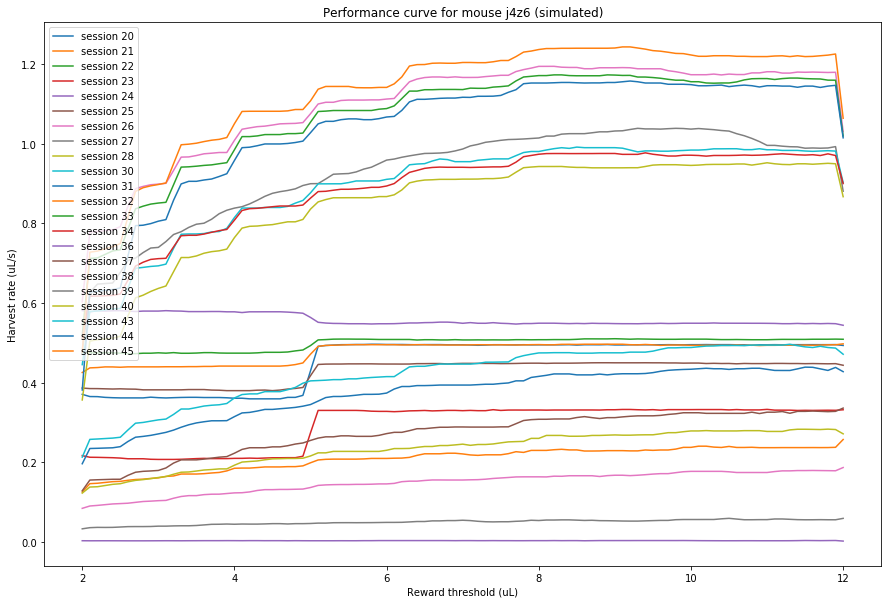

In [526]:
# Calculate optimal simulated performance for each session
harvest_rate_sim = np.zeros(len(filelist))
r_thresh_sim = np.zeros(len(filelist))
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(len(filelist)):
    # Calculate harvest rate mean and std
    mean = np.mean(r_total[i, :, :]/t_total[i, :, :], axis=1)
    std = np.std(r_total[i, :, :]/t_total[i, :, :], axis=1)

    # Smooth curve with 1D median filter
    mean_smooth = np.zeros(mean.shape)
    n = 10 # filter size
    mean_smooth[0] = mean[0] # anchor at ends
    mean_smooth[-1] = mean[-1] # anchor at ends
    for j in range(1, mean.shape[0]-1):
        mean_smooth[j] = np.median(mean[max(j-n//2, 0):min(j+n//2, mean.shape[0]-1)])
    harvest_rate_sim[i] = np.max(mean_smooth)
    r_thresh_sim[i] = decision_val[np.argmax(mean_smooth)]

    # Plot results
    #p_mean = ax.plot(decision_val, mean)
    #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
    p_mean_smooth = ax.plot(decision_val, mean_smooth, label='session %d' % (training_days[i]))
        
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for mouse %s (simulated)' % mouse_id)
l = ax.legend()

# Save plot
plt.savefig(results_dir + 'sim_performance_curves.png')

### Compare simulated vs. observed performance

#### Overall performance

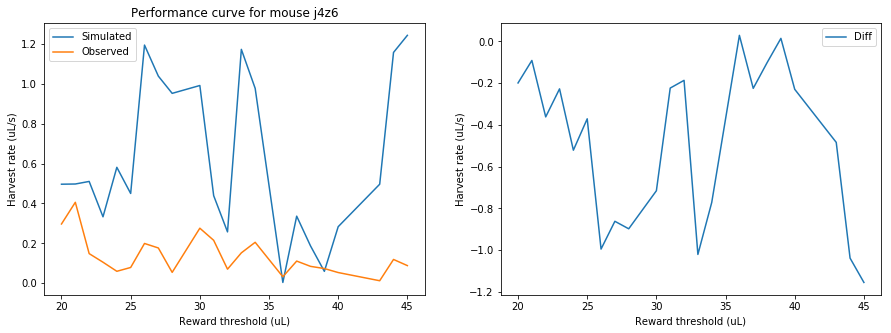

In [527]:
# Make figure, axes
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rates for simulation vs. observed behavior
_ = ax[0].plot(training_days, harvest_rate_sim, label='Simulated')
_ = ax[0].plot(training_days, harvest_rate_obs, label='Observed')
_ = ax[0].set_xlabel('Reward threshold (uL)')
_ = ax[0].set_ylabel('Harvest rate (uL/s)')
_ = ax[0].set_title('Performance curve for mouse %s' % mouse_id)
_ = ax[0].legend()

# Plot difference between two
_ = ax[1].plot(training_days, harvest_rate_obs-harvest_rate_sim, label='Diff')
_ = ax[1].set_xlabel('Reward threshold (uL)')
_ = ax[1].set_ylabel('Harvest rate (uL/s)')
_ = ax[1].legend()

# Save figure
plt.savefig(results_dir + 'sim_vs_obs_performance_curves.png')

#### Best time window

In [528]:
# Settings
window_size = 300 # seconds

# Placeholders
t_window = np.zeros([len(filelist), 2]) # best window
r_window = np.zeros(len(filelist)) # total reward in best window
tt, r_bins = [], [] # for plotting

# Calculate best time window in each session
for i in range(len(filelist)):
    with h5py.File(filelist[i]) as f:
        # Get trial timestamps (seconds)
        try:
            t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        
        except KeyError as err:
            print('Skipping file %s: trials are not timestamped.' % filelist[i])
            t_window[i] = [np.nan, np.nan]
            r_window[i] = np.nan
            tt.append([np.nan])
            r_bins.append([np.nan])
            continue
            
        # Calculate reward over session
        r_trial_ = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_trial = ((result_trial == 0) + (result_trial == 3)) * r_trial_

        # Create one-minute sliding window across session       
        t_total = f['UntitledWheelTime']['Data'][0, -1] # last timestamp
        tt_ = np.arange(0, int(t_total), 60) # one-minute increments

        # Create array of shape [start_time, trial_idx], where each element
        # represents (start_time < t_trial[trial_idx] < start_time + window_size)
        trial_bins = ( (t_trial[np.newaxis, :] > tt_[:, np.newaxis])
                       *(t_trial[np.newaxis, :] < tt_[:, np.newaxis] + window_size) )

        # Find time window with most reward
        try:
            r_bins_ = trial_bins * r_trial[np.newaxis, :] # broadcasted across start times
            tt_max_idx = np.argmax(np.sum(r_bins_, axis=1))
            t_window[i] = [tt_[tt_max_idx], tt_[tt_max_idx]+window_size]
            r_window[i] = np.max(np.sum(r_bins_, axis=1))
            tt.append(tt_)
            r_bins.append(r_bins_)
            
        except ValueError as err:
            print('Skipping file %s: trial and reward shapes do not match.' % filelist[i])
            t_window[i] = [np.nan, np.nan]
            r_window[i] = np.nan
            tt.append([np.nan])
            r_bins.append([np.nan])
            continue

# Save harvest rate of best window
harvest_rate_win = r_window / window_size

Skipping file Z:\James\data\ChamberA\8-16-18\j4z6_d22_2018_08_16_13_58_39.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberA\8-17-18\j4z6_d23_2018_08_17_15_39_42.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberA\8-21-18\j4z6_d25_2018_08_21_13_05_17.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberC\8-22-18\j4z6_d26_2018_08_22_12_05_34.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberA\8-23-18\j4z6_d27_2018_08_23_12_19_41.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberA\9-6-18\j4z6_d34_2018_09_06_09_15_39.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberC\9-11-18\j4z6_d37_2018_09_11_15_04_44.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberC\9-12-18\j4z6_d38_2018_09_12_10_31_01.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberC\9-13-2018\j4z6_d39_2018_09_1

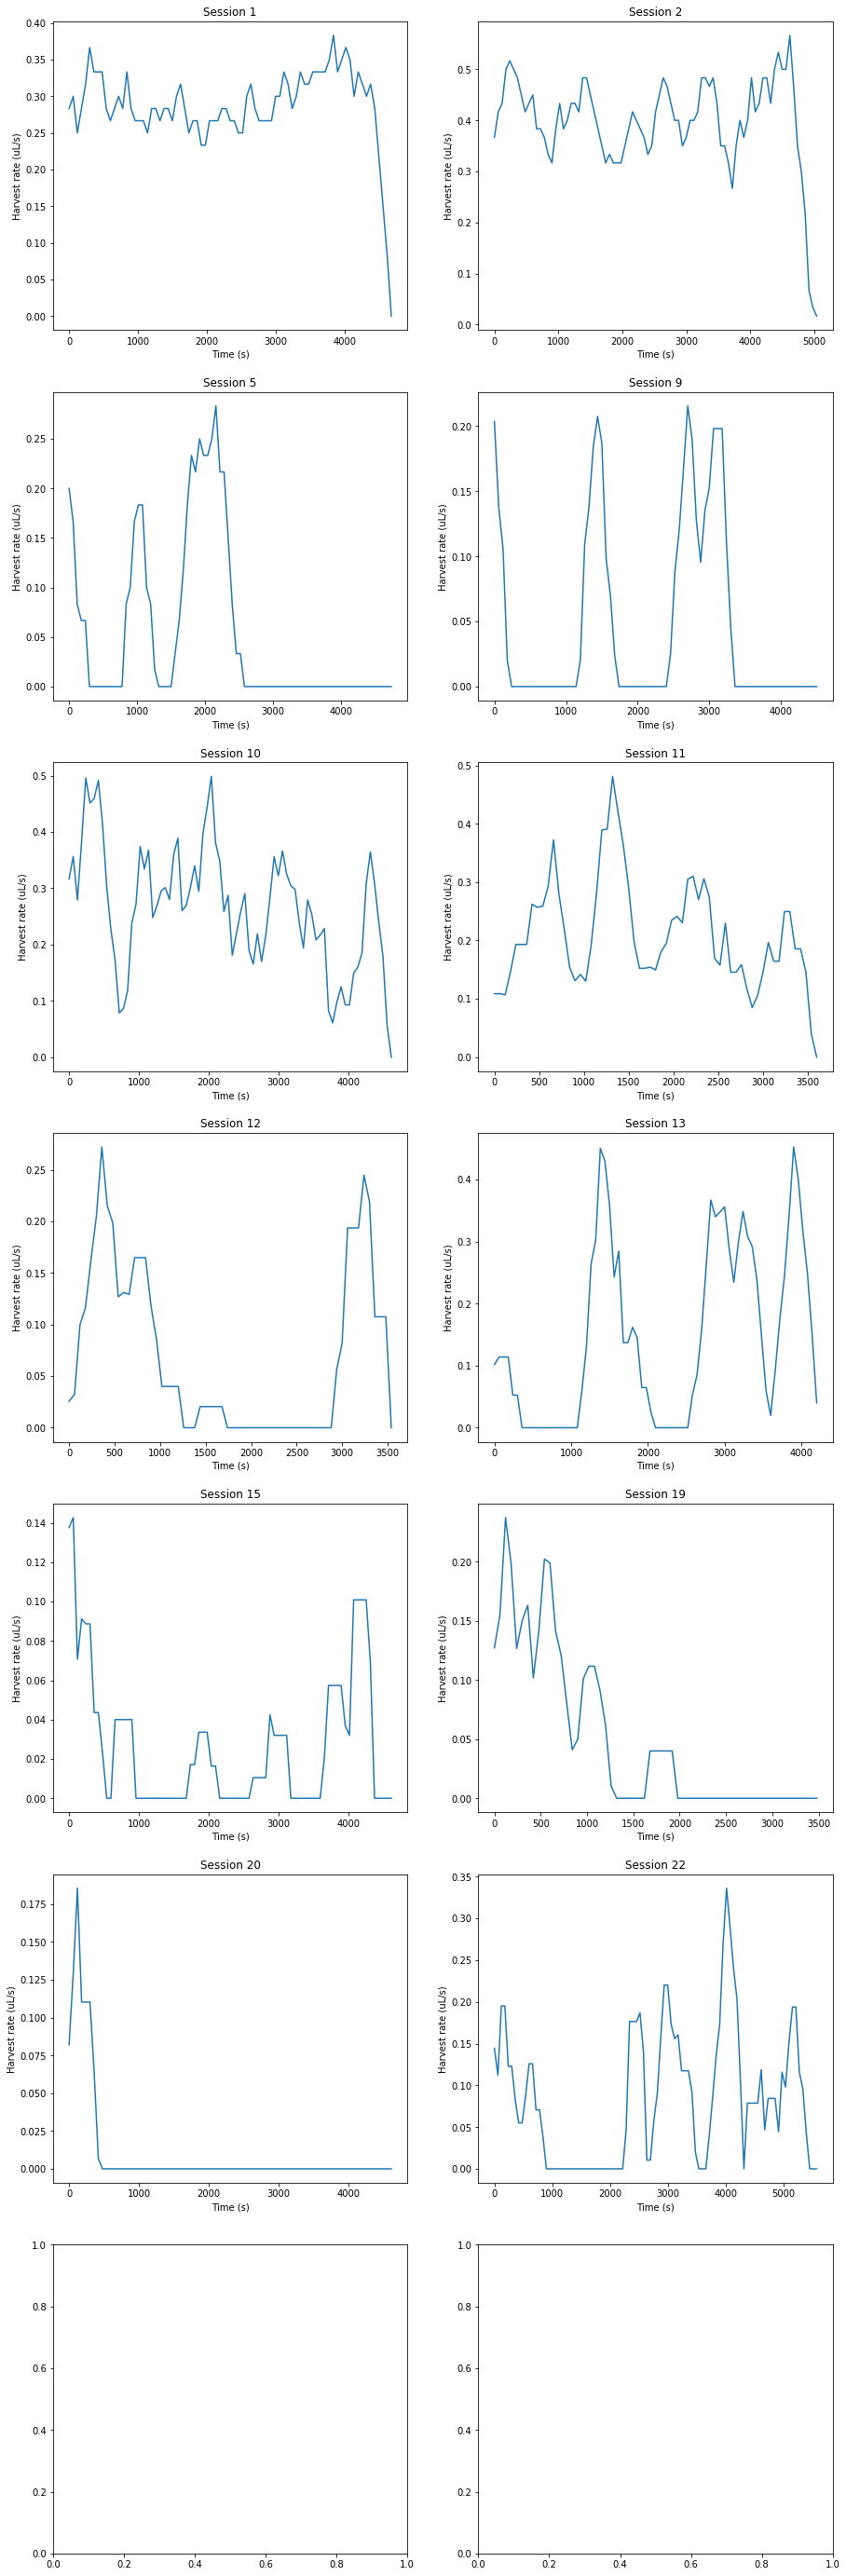

In [529]:
# Determine which sessions to plot
plot_idx = np.zeros(len(r_bins), dtype=np.int16)
for i, rb in enumerate(r_bins):
    if not np.isnan(r_bins[i]).all():
        plot_idx[i] = True

# Plot harvest rate over sliding windows
fig, ax = plt.subplots(np.sum(plot_idx)//2+1, 2, figsize=(15, 50))
for i, j in enumerate(np.argwhere(plot_idx).flatten()):
    _ = ax[i//2, i%2].plot(tt[j], np.sum(r_bins[j], axis=1)/window_size)
    _ = ax[i//2, i%2].set_title('Session %d' % (j+1))
    _ = ax[i//2, i%2].set_xlabel('Time (s)')
    _ = ax[i//2, i%2].set_ylabel('Harvest rate (uL/s)')

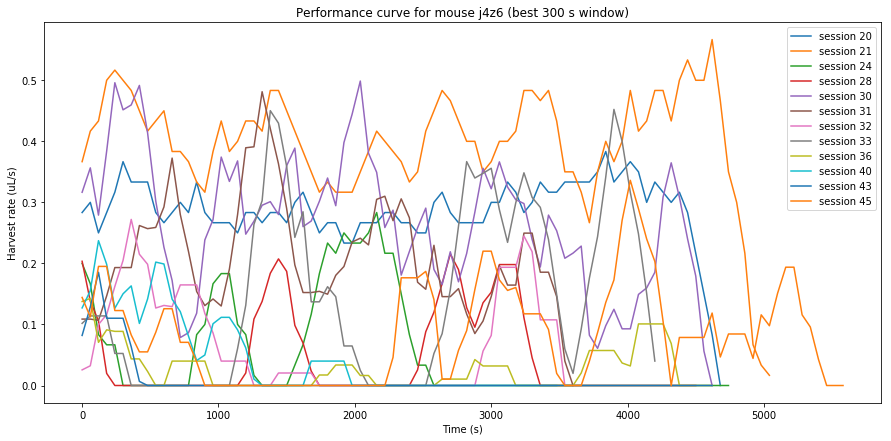

In [530]:
# Plot above in one figure
fig, ax = plt.subplots(figsize=(15, 7))
for j in np.argwhere(plot_idx).flatten():
    _ = ax.plot(tt[j], np.sum(r_bins[j], axis=1)/window_size, 
                label='session %d' % training_days[j])
_ = ax.set_xlabel('Time (s)')
_ = ax.set_ylabel('Harvest rate (uL/s)')
_ = ax.set_title('Performance curve for mouse %s (best %d s window)' % (mouse_id, window_size))
_ = ax.legend()

# Save figure
plt.savefig(results_dir + 'obs_performance_curves_%ds.png' % window_size)

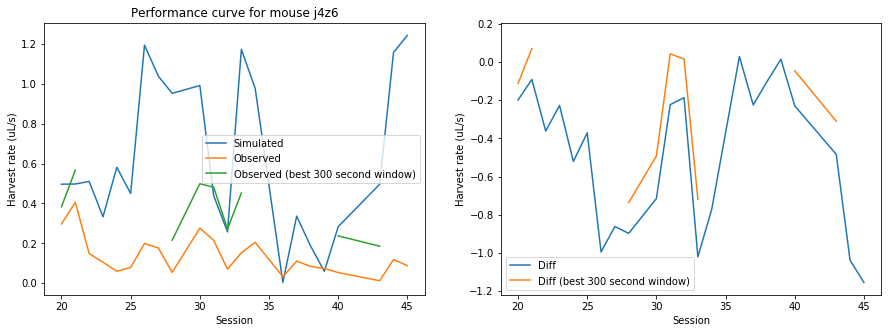

In [531]:
# Make figure, axes
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rates for simulation vs. observed behavior
_ = ax[0].plot(training_days, harvest_rate_sim, label='Simulated')
_ = ax[0].plot(training_days, harvest_rate_obs, label='Observed')
_ = ax[0].plot(training_days, harvest_rate_win, label='Observed (best %d second window)' % window_size)
_ = ax[0].set_xlabel('Session')
_ = ax[0].set_ylabel('Harvest rate (uL/s)')
_ = ax[0].set_title('Performance curve for mouse %s' % mouse_id)
_ = ax[0].legend()

# Plot difference between two
_ = ax[1].plot(training_days, harvest_rate_obs-harvest_rate_sim, label='Diff')
_ = ax[1].plot(training_days, harvest_rate_win-harvest_rate_sim, label='Diff (best %d second window)' % window_size)
_ = ax[1].set_xlabel('Session')
_ = ax[1].set_ylabel('Harvest rate (uL/s)')
_ = ax[1].legend()

# Save figure
plt.savefig(results_dir + 'sim_vs_obs_performance_curves_%ds.png' % window_size)

### Analyze best session(s)

#### Harvest rate per patch

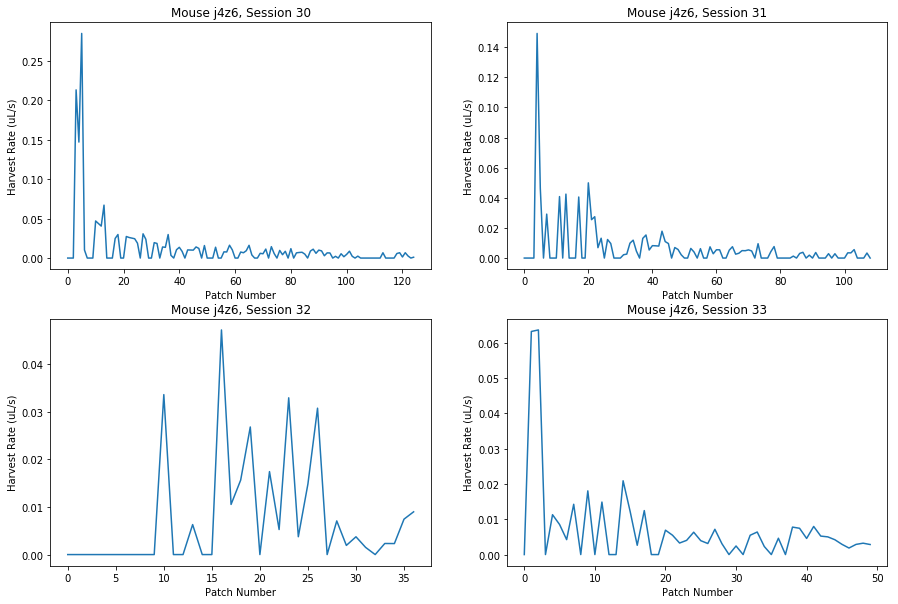

In [605]:
session_id = [30, 31, 32, 33]

idx = np.argwhere(np.isin(training_days, session_id)).flatten()
fig, ax = plt.subplots(max(len(idx)//2, 1), 2, figsize=(15, 5*(max(len(idx)//2, 1))))
for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        # Get trial timestamps (seconds)
        t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0

        # Get patch timestamps
        t_patch_start = (f['UntitledPatchStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        patch_len = f['UntitledPatchTime']['Data'][0, :]
        t_patch_start = np.hstack([np.array([0.0,]), t_patch_start])

        # Bin trials into patches
        trial_patch = ( (t_trial[np.newaxis, :] > t_patch_start[:, np.newaxis])
                       *(t_trial[np.newaxis, :] < (t_patch_start + patch_len)[:, np.newaxis]) )

        # Calculate reward per trial
        r_trial_ = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_trial = ((result_trial == 0) + (result_trial == 3)) * r_trial_

        # Calculate reward per patch
        r_patch = trial_patch * r_trial[np.newaxis, :] # broadcasted across start times
        r_patch = np.sum(r_patch, axis=1)

    try:
        _ = ax[i//2, i%2].plot(r_patch/(t_patch_start + patch_len))
        _ = ax[i//2, i%2].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        _ = ax[i//2, i%2].set_xlabel('Patch Number')
        _ = ax[i//2, i%2].set_ylabel('Harvest Rate (uL/s)')
    except IndexError:
        _ = ax[i].plot(r_patch/(t_patch_start + patch_len))
        _ = ax[i].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        _ = ax[i].set_xlabel('Patch Number')
        _ = ax[i].set_ylabel('Harvest Rate (uL/s)')
    

#### Determine inclusion criteria
The mouse likely has periods of engagement and periods of rest/sleep/disengagement over the course of any session. Rather than simulating the overall metrics (e.g. hit rate, false alarm rate), let's simulate the metrics that represent sliding time windows to reflect how it does within windows in which it is engaged. In order to do this, we must first determine which session(s) (and which parts of those sessions) to include for this analysis.

In [611]:
from scipy.stats import norm

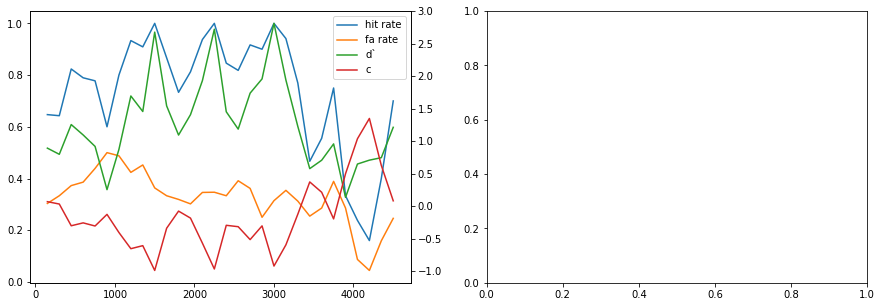

In [652]:
i = 9

dt_bin = 300 # time bin (s)
dt_overlap = dt_bin//2 # overlap (s)
dp_min = 0.0
v_min = 0.02

with h5py.File(filelist[i]) as f:
    # Get trial timestamps (seconds)
    t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0

    # Determine last timestamp
    t_patch_end = (f['UntitledPatchEndms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
    t_total = t_patch_end[-1]
   
    # Bin trials results by time window
    tt_ = np.arange(dt_bin//2, int(t_total), dt_bin - dt_overlap)
    trial_bins = ( (t_trial[np.newaxis, :] > tt_[:, np.newaxis] - dt_bin//2)
                   *(t_trial[np.newaxis, :] < tt_[:, np.newaxis] + dt_bin//2) )
    results = f['UntitledTrialResult']['Data'][0, :] + 1 # shift indices by 1
    results_bins = trial_bins * results[np.newaxis, :]
    
    ### Calculate performance metrics (patch engagement) ###
    # Indices (right-shifted by 1): hit=1, miss=2, fa=3, catch=4, n/a=5
    # For invalid bins (zero number of trial types), default value is zero.
    # Hit rate
    hit_rate = np.zeros(len(tt_))
    n_targets = np.sum((results_bins == 1) + (results_bins == 2), axis=1)
    hit_idx = np.argwhere(n_targets > 0).flatten()
    hit_rate[hit_idx] = np.sum((results_bins == 1), axis=1)[hit_idx] / n_targets[hit_idx]
    
    # False alarm rate    
    struct = f['Settings']['Property']
    bin_width = float([u''.join(chr(c) for c in struct['SoundConfigurationToneCloudConfigTimeBinWidthms'])][0])
    dt_nc = f['UntitledNCTimechord']['Data'][0, :] * bin_width / 1000.0
    target_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigTargetDurationsec'])][0])
    dt_nc_bins = trial_bins * dt_nc[np.newaxis, :]
    n_cr = np.sum((dt_nc_bins / target_duration).astype(np.int32), axis=1) # or reaction time?
    n_fa = np.sum((results_bins == 3), axis=1)
    fa_rate = n_fa / (n_fa + n_cr)

    # d prime, bias
    hit_rate_ = np.maximum(np.minimum(hit_rate, 0.99), 0.01); # avoids z = +/-inf
    fa_rate_ = np.maximum(np.minimum(fa_rate, 0.99), 0.01); # avoids z = +/-inf
    z_hit_rate = norm.ppf(hit_rate_, loc=0.0, scale=1.0)
    z_fa_rate = norm.ppf(fa_rate_, loc=0.0, scale=1.0)
    dp = z_hit_rate - z_fa_rate
    c = -(z_hit_rate + z_fa_rate) / 2 # note negative sign
    
    ### Calculate time walking (interpatch engagement) ###
    v_t = f['']
    
    
    

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
l1 = ax[0].plot(tt_, hit_rate, label='hit rate')
l2 = ax[0].plot(tt_, fa_rate, label='fa rate')
ax2 = ax[0].twinx()
for _ in range(2):
    next(ax2._get_lines.prop_cycler)
l3 = ax2.plot(tt_, dp, label='d`')
l4 = ax2.plot(tt_, c, label='c')
lns = l1 + l2 + l3 + l4
labs = [l.get_label() for l in lns]
_ = ax[0].legend(lns, labs)

In [619]:
f = h5py.File(filelist[i])
print(f['UntitledS_HitRate']['Data'][0, 0] / 100.0)
print(f['UntitledS_FARate']['Data'][0, 0] / 100.0)
t_nc = f['UntitledNCTimechord']['Data'][0, :]

0.7079646017699115
0.2576372785784721


In [ ]:
f = h5py.File(filelist[i])
t = f['UntitledWheelTime']['Data'][0, :]
v = f['UntitledWheelSpeed']['Data'][0, :]
dt = f['UntitledWheelTime']['Property']['wf_increment'][0]

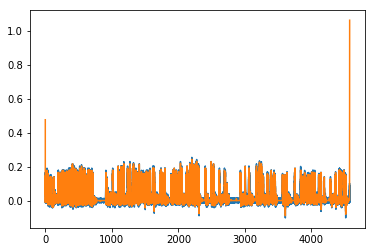

In [666]:
#from scipy.interpolate import interp1d
#v_t = interp1d(t * t_total/t[-1], v)
#tt = np.linspace(0, t_total, 5000)
#plt.figure(figsize=(15, 10))
#plt.plot(tt, v_t(tt))
plt.plot(t*t_total/t[-1], v)
filt = np.
    
plt.plot(t*t_total/t[-1], v_smooth)
# Plot patch and interpatch times to see if aligned

#### Determining exclusion criteria

In [668]:
i=9

## Reinforcement Learning Model

In [ ]:
class PatchEnvironment:
    
    def __init__(self, 
                 d_patch, 
                 d_interpatch, 
                 r_init, 
                 r_decay, 
                 episode_timeout):
        
        self.d_patch = d_patch
        self.d_interpatch = d_interpatch
        self.r_init = r_init
        self.r_decay = r_decay
        self.trial = 0
        self.step = 0
        self.episode_timeout = episode_timeout
        
    
        
    def _harvest_reward(self):
        """
        Give reward according exponential decay function for trial number in patch.
        """
        
        
        

In [ ]:
class Mouse:
    
    def __init__(self, 
                 hit_rate, 
                 fa_rate, 
                 velocity, 
                 thresh_type='reward', 
                 thresh_val=2.0):
        
        
    
    def make_action(self, action):
        """
        Either choose to stay in patch (and harvest reward) or leave patch (and incur travel time delay).
        """
        if action == 0: # stay in patch
            r = self._harvest_reward()
        else:
            r = self._leave_patch()
        
        
        self.step += 1
        is_terminal = self.step > episode_timeout
        
        return r, is_terminal